In [17]:
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [18]:
from predict_next_token_in_time_series import *

# Generate data

In [19]:
n0 = 300
episodes = np.empty((0, 101))
for C in [1e-8, 3e-8, 5e-8, 7e-8, 8e-8]:
    for l0 in [0.0045, 0.003, 0.0015, 0.0007, 0.0001]:
        paris = ParisLawDegradation(length=100, dim=1, C=C)
        episodes_i = paris.generate_episode(x0=np.random.randn(n0)*0.0003+l0)  # Initial crack lengths in meters
        episodes = np.concatenate([episodes, episodes_i], axis=0)

#drop invalid values
episodes = episodes[~np.isnan(episodes).any(axis=1)]
episodes = episodes[(episodes<1).all(axis=1)]
episodes.shape

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:44: RuntimeWarning:

invalid value encountered in sqrt

/Users/Mohammad/Documents/ds-projects/deg-predict-demo/degradation-transformer/predict_next_token_in_time_series.py:48: RuntimeWarning:

overflow encountered in power



(5722, 101)

In [20]:
episodes.max()

np.float64(0.9901558211374489)

In [26]:


# Check default device
device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
#device = torch.device('cpu')  # Force CPU for consistency in this example
print("Default Device:", device)

Default Device: mps


In [22]:
print(f"Min: {episodes.min()}")
print(f"Max: {episodes.max()}")

Min: 7.825814127358343e-08
Max: 0.9901558211374489


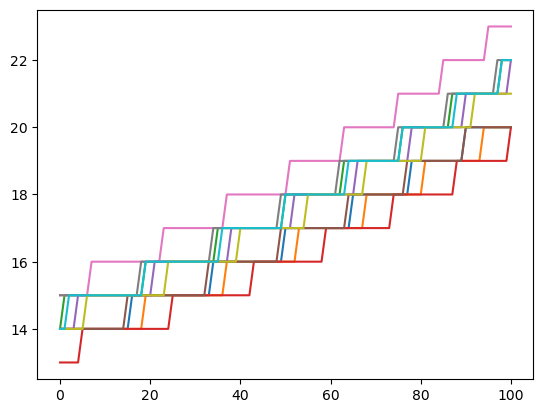

In [23]:
vocab_size=3000
digitized_episodes = digitize_np(episodes, 0, episodes.max()+0.01, vocab_size)
plt.plot(digitized_episodes[:10].T)


# Set up model and training params

In [24]:


# Split episodes into train/test (e.g., 80/20)
n_train = int(0.8 * len(digitized_episodes))
train_episodes = digitized_episodes[:n_train]
test_episodes = digitized_episodes[n_train:]
train_dataset = TimeSeriesDataset(train_episodes)
test_dataset = TimeSeriesDataset(test_episodes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True, num_workers=2)
model = DegradationTransformer(vocab_size=vocab_size, context_window=40, 
                               embedding_dim=128, num_heads=8, num_blocks=4).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.002)
loss_func = torch.nn.CrossEntropyLoss()
len(train_loader), len(test_loader)
cbs = [ProgressCallback(20)]
learner = Learner(model, optim, loss_func, train_loader, test_loader, cbs, device=device)
learner.fit(3)